In [1]:
%run /Users/denis/Documents/Projects/scripts/init.ipy
import math
os.chdir('..')

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


### Infiles

In [56]:
# Annotation
annotation_files = {
    'p100': 'p100/s2-annotations.dir/p100-sample_annotations.txt',
    'l1000': 'l1000/s2-annotations.dir/l1000-sample_annotations.txt',
    'cycif': 'cycif/s1-data.dir/HMS_Datasets-merged_filtered.txt'
}

# Expression
expression_files = {
    'p100': 'p100/s1-data.dir/p100-data.txt',
    'l1000': 'l1000/s1-expression_data.dir/l1000-data.txt',
    'cycif': 'cycif/s1-data.dir/HMS_Datasets-merged_filtered.txt'
}

### Computation

##### Samples

In [57]:
# Read data
annotation_dataframes = {key: pd.read_table(value) for key, value in annotation_files.iteritems()}

In [64]:
# Get P100 design
p100_design_dataframe = annotation_dataframes['p100'].groupby(['pert_iname', 'pert_dose', 'pert_time']).size().rename('count').to_frame().reset_index()
p100_design_dataframe['pert_iname'] = [x.lower() for x in p100_design_dataframe['pert_iname']]
p100_design_dataframe.rename(columns={'pert_iname': 'drug', 'pert_time': 'timepoint', 'pert_dose': 'dose'}, inplace=True)
p100_design_dataframe['type'] = 'p100'
p100_design_dataframe['timepoint'] = p100_design_dataframe['timepoint'].astype('int')
p100_design_dataframe.head()

,drug,dose,timepoint,count,type
0,alpelisib,1.000000,3,3,p100
1,alpelisib,3.162278,3,3,p100
2,alpelisib,10.000000,3,3,p100
3,byl719,10.000000,6,2,p100
4,byl719,10.000000,24,2,p100


In [65]:
print p100_design_dataframe.groupby(['drug', 'dose']).size()

drug            dose     
alpelisib       1.000000     1
                3.162278     1
                10.000000    1
byl719          10.000000    4
dasatinib       0.032000     4
                0.100000     5
                0.316000     4
                0.316228     1
                1.000000     1
dmso            0.000000     5
etoposide       0.100000     1
                0.316000     4
                0.316228     1
                1.000000     1
neratinib       0.031600     1
                0.099928     1
                0.100000     4
                0.316000     1
palbociclib     3.160000     4
pd-0332991      0.316000     1
                1.000000     1
                3.160000     1
staurosporine   1.000000     1
taxol           0.001000     1
                0.003000     4
                0.003162     1
                0.010000     1
trametinib      0.001000     5
                0.003000     4
                0.003162     1
                0.010000     5
vorinostat   

In [53]:
# Get L1000 design
l1000_design_dataframe = annotation_dataframes['l1000'].fillna(0).groupby(['pert_iname', 'pert_dose', 'pert_time']).size().rename('count').to_frame().reset_index().replace('DMSO', 'dmso')
l1000_design_dataframe.rename(columns={'pert_iname': 'drug', 'pert_time': 'timepoint', 'pert_dose': 'dose'}, inplace=True)
l1000_design_dataframe['type'] = 'l1000'
l1000_design_dataframe['timepoint'] = l1000_design_dataframe['timepoint'].astype('int')
l1000_design_dataframe.head()

,drug,dose,timepoint,count,type
0,dmso,0.00,3,149,l1000
1,dmso,0.00,24,146,l1000
2,alpelisib,0.04,3,3,l1000
3,alpelisib,0.04,24,3,l1000
4,alpelisib,0.12,3,3,l1000


In [54]:
print l1000_design_dataframe.groupby(['drug', 'dose']).size()

drug         dose 
alpelisib    0.04     2
             0.12     2
             0.37     2
             1.11     2
             3.33     2
             10.00    2
dasatinib    0.04     2
             0.12     2
             0.37     2
             1.11     2
             3.33     2
             10.00    2
dmso         0.00     2
neratinib    0.04     2
             0.12     2
             0.37     2
             1.11     2
             3.33     2
             10.00    2
palbociclib  0.04     2
             0.12     2
             0.37     2
             1.11     2
             3.33     2
             10.00    2
trametinib   0.04     2
             0.12     2
             0.37     2
             1.11     2
             3.33     2
             10.00    2
dtype: int64


In [34]:
# Get CycIF design
cycif_design_dataframe = (annotation_dataframes['cycif'].groupby(['DrugName', 'Conc', 'timepoint']).size()/2).rename('count').to_frame().reset_index()
cycif_design_dataframe['DrugName'] = [x.lower() for x in cycif_design_dataframe['DrugName']]
cycif_design_dataframe['timepoint'] = [int(x.replace('h', '')) for x in cycif_design_dataframe['timepoint']]
cycif_design_dataframe.rename(columns={'DrugName': 'drug', 'Conc': 'dose'}, inplace=True)
cycif_design_dataframe['type'] = 'cycif'
print cycif_design_dataframe.dose.value_counts()
print cycif_design_dataframe.drug.value_counts()
cycif_design_dataframe.head()

0.100000     24
0.031623     24
0.010000     24
0.316230     21
1.000000     18
3.162300     15
10.000000    15
0.001000      9
0.003162      6
0.000300      3
0.000320      3
0.003200      3
0.000100      3
0.000000      3
Name: dose, dtype: int64
alpelisib      21
etoposide      21
paclitaxel     21
trametinib     21
vorinostat     21
neratinib      21
palbociclib    21
dasatinib      21
dmso            3
Name: drug, dtype: int64


,drug,dose,timepoint,count,type
0,alpelisib,0.010000,24,1301.0,cycif
1,alpelisib,0.010000,48,4587.0,cycif
2,alpelisib,0.010000,72,14293.0,cycif
3,alpelisib,0.031623,24,1245.0,cycif
4,alpelisib,0.031623,48,4311.0,cycif


In [55]:
print cycif_design_dataframe.groupby(['drug', 'dose']).size()

drug         dose     
alpelisib    0.010000     3
             0.031623     3
             0.100000     3
             0.316230     3
             1.000000     3
             3.162300     3
             10.000000    3
dasatinib    0.010000     3
             0.031623     3
             0.100000     3
             0.316230     3
             1.000000     3
             3.162300     3
             10.000000    3
dmso         0.000000     3
etoposide    0.010000     3
             0.031623     3
             0.100000     3
             0.316230     3
             1.000000     3
             3.162300     3
             10.000000    3
neratinib    0.001000     3
             0.003200     3
             0.010000     3
             0.031623     3
             0.100000     3
             0.316230     3
             1.000000     3
paclitaxel   0.000100     3
             0.000320     3
             0.001000     3
             0.003162     3
             0.010000     3
             0.031623    

In [66]:
# Merged design
merged_design_dataframe = pd.concat([p100_design_dataframe, l1000_design_dataframe, cycif_design_dataframe])
merged_design_dataframe['dose'] = [round(x, 1) for x in merged_design_dataframe['dose']]
merged_design_dataframe.head()

,drug,dose,timepoint,count,type
0,alpelisib,1.0,3,3.0,p100
1,alpelisib,3.2,3,3.0,p100
2,alpelisib,10.0,3,3.0,p100
3,byl719,10.0,6,2.0,p100
4,byl719,10.0,24,2.0,p100


In [67]:
# Merged design
assay_count_dataframe = merged_design_dataframe.drop('count', axis=1).drop_duplicates().reset_index(drop=True).query('timepoint==24').drop('timepoint', axis=1).groupby(['drug', 'dose']).size().rename('assays').to_frame().reset_index()
assay_count_dataframe.head()

,drug,dose,assays
0,alpelisib,0.0,2
1,alpelisib,0.1,2
2,alpelisib,0.3,1
3,alpelisib,0.4,1
4,alpelisib,1.0,1


In [68]:
# Count
count_dataframe = pd.pivot_table(assay_count_dataframe, index='drug', columns='dose', values='assays').fillna(0)
count_dataframe

dose,0.0,0.1,0.3,0.4,1.0,1.1,3.2,3.3,10.0
drug,,,,,,,,,
alpelisib,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0
byl719,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
dasatinib,3.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0
dmso,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
etoposide,1.0,1.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0
neratinib,2.0,3.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
paclitaxel,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
palbociclib,2.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0
taxol,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


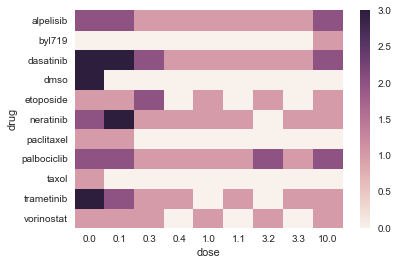

In [69]:
sns.heatmap(count_dataframe)